In [11]:
from opt.mc_sim import *
import time
from common.variables import *

In [12]:
# sourcingEnv = SourcingEnv(
#         lambda_arrival = 8, # or 10
#         procurement_cost_vec = np.array([3, 1, 2]),
#         supplier_lead_times_vec = np.array([0.8, 0.5, 1.0]),
#         on_times = np.array([1, 1, 2]), 
#         off_times = np.array([0.3, 1, 0.2]))

# Dual Sourcing
sourcingEnv = SourcingEnv(
        lambda_arrival = LAMBDA, # or 10
        procurement_cost_vec = np.array([3, 1]),
        supplier_lead_times_vec = np.array([0.8, 0.5]),
        on_times = np.array([1, 1]), 
        off_times = np.array([0.3, 1]))

s_custom = MState(stock_level = 50, 
    n_suppliers = N_SUPPLIERS, 
    n_backorders = np.array([0, 0]), 
    flag_on_off = np.array([1, 1]))

mc_avg_costs = mc_with_ss_policy(sourcingEnv, start_state = s_custom)

# print(mc_avg_costs)

In [13]:
print(s_custom)

Stock: 50, n backorders: [0 0], supplier status (on/off): [1 1]


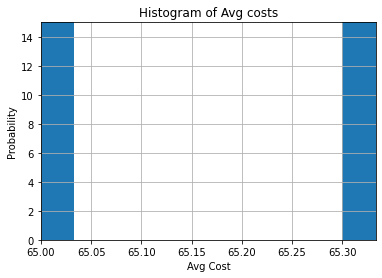

In [14]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 0.3
# n, bins, patches = plt.hist(mc_avg_costs, bins=np.arange( np.min(mc_avg_costs), np.max(mc_avg_costs) + binwidth, binwidth))
n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs), np.max(mc_avg_costs))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [15]:
print(np.mean(np.array(mc_avg_costs)))

65.16666666666666


In [16]:
np.std(np.array(mc_avg_costs))

0.1666666666666643

In [17]:
print(sourcingEnv.reset())

Stock: 0, n backorders: [0. 0.], supplier status (on/off): [1. 1.]


In [18]:
repr(str(sourcingEnv.reset()))

"'Stock: 0, n backorders: [0. 0.], supplier status (on/off): [1. 1.]'"

In [19]:
import pickle as pkl

filename = "saved_models/msource_value_dic_06-16-2022-09-56-03.pkl"

with open(filename, 'rb') as f:
    value_dic = pkl.load(f)

-7.037139689578714

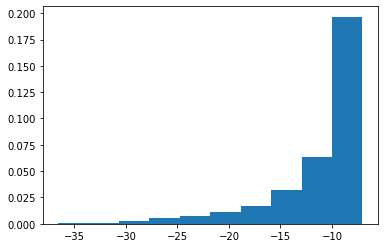

In [23]:
import numpy as np

binwidth = 0.3


state_vals = list(value_dic.values())

n, bins, patches = plt.hist(state_vals, density = True)
np.max(state_vals)

In [24]:
state_vals

[-8.12250554323725,
 -7.927383592017737,
 -7.972838137472284,
 -8.19179600886918,
 -7.849778270509978,
 -7.8752771618625275,
 -8.015521064301554,
 -8.041574279379159,
 -8.00609756097561,
 -8.005543237250555,
 -8.168514412416851,
 -8.118070953436808,
 -7.8414634146341475,
 -8.56541019955654,
 -8.53048780487805,
 -7.929600886917962,
 -7.833148558758316,
 -8.73059866962306,
 -7.8586474501108645,
 -7.866407982261641,
 -7.953436807095346,
 -7.734478935698448,
 -8.273281596452328,
 -7.891352549889137,
 -9.297671840354766,
 -8.363636363636363,
 -7.840354767184035,
 -7.748891352549889,
 -8.540465631929045,
 -10.684035476718403,
 -8.012749445676274,
 -7.869179600886918,
 -11.14689578713969,
 -8.133037694013304,
 -8.007760532150776,
 -11.324833702882485,
 -11.180155210643015,
 -11.798226164079823,
 -9.624168514412416,
 -10.90022172949002,
 -11.648558758314858,
 -12.000554323725053,
 -9.390243902439025,
 -9.819844789356985,
 -10.129157427937914,
 -12.608647450110867,
 -8.067073170731707,
 -8.0953